# Prevalence Sensitivity Analysis

This notebook evaluates how the cost-effectiveness of AI-enhanced glaucoma screening varies across different disease prevalence levels.

---

## Overview

**Objective**: Assess the impact of glaucoma prevalence on the cost-effectiveness of AI screening.

**Rationale**: Screening programs are more efficient in higher-prevalence populations because:
- Higher proportion of true positives
- Lower cost per case detected
- Fewer false positives per true positive

**Analysis Approach**:
1. Run base case PSA (AI and Non-AI models)
2. Adjust screening costs for each prevalence level
3. Calculate cost-effectiveness at each prevalence
4. Compare results across prevalence scenarios

**Prevalence Scenarios Tested**:
- 1% (low-risk population)
- 2% (general population - lower bound)
- 5% (base case)
- 6% (general population - upper bound)
- 7% (enriched population)
- 10% (high-risk population)

## 1. Setup and Imports

In [13]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy

sys.path.append('../src')

from glaucoma_model.parameters import (
    Parameter,
    GlaucomaParameters
)

from glaucoma_model.model import (
    BaseGlaucomaModel,
    AIGlaucomaModel,
    NonAIGlaucomaModel
)

from glaucoma_model.utils import (
    run_prevalence_sensitivity_analysis,
    summarize_prevalence_sensitivity,
    save_scenario_results
)

from glaucoma_model.analysis import comprehensive_cost_effectiveness_analysis

print("✓ Imports complete")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ Imports complete


## 2. Configuration

Define base case parameters and prevalence scenarios

In [14]:
# Base case PSA parameters
N_ITERATIONS = 5000
YEARS = 30
STARTING_AGE = 61
MALE_PROPORTION = 0.55
RANDOM_SEED = 42

# Prevalence scenarios to analyze
PREVALENCE_VALUES = [0.01, 0.02, 0.05, 0.06, 0.07, 0.10]

# Analysis parameters
TIME_HORIZONS = [5, 10, 15, 20, 30]
WTP_THRESHOLDS = [0, 20000, 50000, 75000, 100000, 150000, 200000]
CONFIDENCE_LEVEL = 0.95

print("=== CONFIGURATION ===")
print(f"\nBase Case PSA:")
print(f"  Iterations: {N_ITERATIONS:,}")
print(f"  Time horizon: {YEARS} years")
print(f"  Starting age: {STARTING_AGE}")
print(f"  Random seed: {RANDOM_SEED}")

print(f"\nPrevalence Sensitivity:")
print(f"  Scenarios: {[f'{p:.1%}' for p in PREVALENCE_VALUES]}")
print(f"  Time horizons: {TIME_HORIZONS} years")
print(f"  WTP thresholds: {[f'€{t:,}' for t in WTP_THRESHOLDS]}")

=== CONFIGURATION ===

Base Case PSA:
  Iterations: 5,000
  Time horizon: 30 years
  Starting age: 61
  Random seed: 42

Prevalence Sensitivity:
  Scenarios: ['1.0%', '2.0%', '5.0%', '6.0%', '7.0%', '10.0%']
  Time horizons: [5, 10, 15, 20, 30] years
  WTP thresholds: ['€0', '€20,000', '€50,000', '€75,000', '€100,000', '€150,000', '€200,000']


## 3. Initialize Models and Run Base Case PSA

Create AI and Non-AI models with base case parameters

In [4]:
print("Initializing models...")

# Initialize AI model
model_ai = AIGlaucomaModel(starting_age=STARTING_AGE)
model_ai.load_mortality_table_from_file(
    filepath_male='../data/male_mortality_2023.csv',
    filepath_female='../data/female_mortality_2023.csv',
    male_proportion=MALE_PROPORTION
)

# Initialize Non-AI model
model_non_ai = NonAIGlaucomaModel(starting_age=STARTING_AGE)
model_non_ai.load_mortality_table_from_file(
    filepath_male='../data/male_mortality_2023.csv',
    filepath_female='../data/female_mortality_2023.csv',
    male_proportion=MALE_PROPORTION
)

# Store base case prevalence
base_case_prevalence = model_ai.params.screening_params['prevalence_general'].mean

print("✓ Models initialized")
print(f"\nBase case prevalence: {base_case_prevalence:.1%}")

Initializing models...
Applied Non-AI cost structure: Only VI patients incur costs
✓ Models initialized

Base case prevalence: 5.0%


## 4. Define Initial Distribution

In [5]:
# Initial distribution: 38 mild, 9 moderate, 7 severe, 0 VI, 0 dead
initial_dist = [38, 9, 7, 0, 0]
initial_dist = np.array(initial_dist) / np.sum(initial_dist)

print("=== INITIAL DISTRIBUTION ===")
print(f"Mild:     {initial_dist[0]:.2%}")
print(f"Moderate: {initial_dist[1]:.2%}")
print(f"Severe:   {initial_dist[2]:.2%}")
print(f"VI:       {initial_dist[3]:.2%}")
print(f"Dead:     {initial_dist[4]:.2%}")

=== INITIAL DISTRIBUTION ===
Mild:     70.37%
Moderate: 16.67%
Severe:   12.96%
VI:       0.00%
Dead:     0.00%


## 5. Run Base Case PSA

Execute probabilistic sensitivity analysis for both models

### 5.1 AI Model PSA

In [6]:
print(f"Running AI Model PSA with {N_ITERATIONS:,} iterations...")

ai_psa_results = model_ai.run_probabilistic(
    n_iterations=N_ITERATIONS,
    initial_dist=initial_dist,
    years=YEARS,
    include_screening=True,
    population_type='general',
    random_seed=RANDOM_SEED,
    return_traces=True
)

print("✓ AI Model PSA complete")

Running AI Model PSA with 5,000 iterations...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500/5000
  AI Model Iteration 2600/5000
  AI Model Iteration 2700/5000
  AI Model Iteration 2800/5000
  AI Model Iteration 29

### 5.2 Non-AI Model PSA

In [7]:
print(f"Running Non-AI Model PSA with {N_ITERATIONS:,} iterations...")

non_ai_psa_results = model_non_ai.run_probabilistic(
    n_iterations=N_ITERATIONS,
    initial_dist=initial_dist,
    years=YEARS,
    include_screening=True,
    population_type='general',
    random_seed=RANDOM_SEED,
    return_traces=True
)

print("✓ Non-AI Model PSA complete")

Running Non-AI Model PSA with 5,000 iterations...
Running 5000 PSA iterations for Traditional Non-AI Model (Starting Age: 61)...
  Non-AI Model Iteration 100/5000
  Non-AI Model Iteration 200/5000
  Non-AI Model Iteration 300/5000
  Non-AI Model Iteration 400/5000
  Non-AI Model Iteration 500/5000
  Non-AI Model Iteration 600/5000
  Non-AI Model Iteration 700/5000
  Non-AI Model Iteration 800/5000
  Non-AI Model Iteration 900/5000
  Non-AI Model Iteration 1000/5000
  Non-AI Model Iteration 1100/5000
  Non-AI Model Iteration 1200/5000
  Non-AI Model Iteration 1300/5000
  Non-AI Model Iteration 1400/5000
  Non-AI Model Iteration 1500/5000
  Non-AI Model Iteration 1600/5000
  Non-AI Model Iteration 1700/5000
  Non-AI Model Iteration 1800/5000
  Non-AI Model Iteration 1900/5000
  Non-AI Model Iteration 2000/5000
  Non-AI Model Iteration 2100/5000
  Non-AI Model Iteration 2200/5000
  Non-AI Model Iteration 2300/5000
  Non-AI Model Iteration 2400/5000
  Non-AI Model Iteration 2500/5000
  Non

## 6. Adjust for AI Screening Sensitivity and Specificity

Create base case results adjusted for screening performance

In [8]:
print("Adjusting AI results for sensitivity and specificity...")

# Get trace tensors and variable names
ai_traces = ai_psa_results['trace_tensor']
non_ai_traces = non_ai_psa_results['trace_tensor']
trace_variable_names = ai_psa_results['trace_variable_names']

# Create adjusted AI results
ai_eff0_psa_traces = copy.deepcopy(ai_traces)
ai_eff0_psa_results = copy.deepcopy(ai_psa_results)

# Get sensitivity and specificity
sensitivity_value = model_ai.params.screening_accuracy['sensitivity'].mean
specificity_value = model_ai.params.screening_accuracy['specificity'].mean

print(f"Sensitivity: {sensitivity_value:.1%}")
print(f"Specificity: {specificity_value:.1%}")

# Adjust costs
for var_name in ['Total_Cost', 'Total_Cost_Disc']:
    if var_name in trace_variable_names:
        var_idx = trace_variable_names.index(var_name)
        ai_eff0_psa_traces[:, :, var_idx] = (
            sensitivity_value * ai_traces[:, :, var_idx] +
            (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
        )

# Adjust QALYs
qaly_vars = ['Total_QALY', 'Total_QALY_Disc', 'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI']
for var_name in qaly_vars:
    if var_name in trace_variable_names:
        var_idx = trace_variable_names.index(var_name)
        ai_eff0_psa_traces[:, :, var_idx] = (
            sensitivity_value * ai_traces[:, :, var_idx] +
            (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
        )

ai_eff0_psa_results['trace_tensor'] = ai_eff0_psa_traces

print("✓ Sensitivity/specificity adjustment complete")

Adjusting AI results for sensitivity and specificity...
Sensitivity: 77.5%
Specificity: 95.4%
✓ Sensitivity/specificity adjustment complete


## 7. Add Base Case Screening Costs

Add AI screening costs and false positive follow-up costs

In [9]:
print("Adding screening costs...")

# Get cost indices
idx_cost = trace_variable_names.index('Total_Cost')
idx_cost_disc = trace_variable_names.index('Total_Cost_Disc')

# Get parameters
ai_screening_cost = model_ai.params.costs['ai_screening'].mean
human_screening_cost = model_ai.params.costs['human_screening'].mean

# Calculate per-case costs at base prevalence
ai_screening_per_case = (1/base_case_prevalence) * ai_screening_cost
false_positives_per_case = ((1 - base_case_prevalence) / base_case_prevalence) * (1 - specificity_value)
fp_cost_per_case = false_positives_per_case * human_screening_cost
total_screening_cost = ai_screening_per_case + fp_cost_per_case

print(f"\nBase Case Screening Costs (prevalence = {base_case_prevalence:.1%}):")
print(f"  AI screening per case: €{ai_screening_per_case:,.2f}")
print(f"  False positive cost: €{fp_cost_per_case:,.2f}")
print(f"  Total: €{total_screening_cost:,.2f}")

# Add screening costs at year 0
ai_eff0_psa_results['trace_tensor'][:, 0, idx_cost] += total_screening_cost
ai_eff0_psa_results['trace_tensor'][:, 0, idx_cost_disc] += total_screening_cost

print("\n✓ Base case screening costs added")

Adding screening costs...

Base Case Screening Costs (prevalence = 5.0%):
  AI screening per case: €233.00
  False positive cost: €187.91
  Total: €420.91

✓ Base case screening costs added


## 8. Prepare Base Case Data for Prevalence Analysis

Package base case results in the format needed for prevalence sensitivity analysis

In [15]:
print("Preparing base case data...")

# Extract model parameters as dictionary
model_params_dict = {
    'costs': model_ai.params.costs,
    'utilities': model_ai.params.utilities,
    'transitions': model_ai.params.transitions,
    'screening_accuracy': model_ai.params.screening_accuracy,
    'screening_params': model_ai.params.screening_params,
    'discount_rates': model_ai.params.discount_rates
}

# Create base_case dictionary in the format expected by run_prevalence_sensitivity_analysis
base_case = {
    'ai_results': ai_eff0_psa_results,
    'non_ai_results': non_ai_psa_results,
    'model_params': model_params_dict,
    'variable_names': trace_variable_names,
    'original_prevalence': base_case_prevalence
}

print("✓ Base case data prepared")
print(f"\nBase Case Summary:")
print(f"  AI PSA iterations: {base_case['ai_results']['trace_tensor'].shape[0]:,}")
print(f"  Non-AI PSA iterations: {base_case['non_ai_results']['trace_tensor'].shape[0]:,}")
print(f"  Time horizon: {base_case['ai_results']['trace_tensor'].shape[1]} years")
print(f"  Variables tracked: {len(base_case['variable_names'])}")
print(f"  Base prevalence: {base_case['original_prevalence']:.1%}")

Preparing base case data...
✓ Base case data prepared

Base Case Summary:
  AI PSA iterations: 5,000
  Non-AI PSA iterations: 5,000
  Time horizon: 31 years
  Variables tracked: 28
  Base prevalence: 5.0%


## 9. Understanding Prevalence Impact

### How Prevalence Affects Cost-Effectiveness

**Screening Cost Per Case Detected:**
- Screening cost per detected case = (AI screening cost) / prevalence
- At 1% prevalence: Need to screen 100 people to find 1 case
- At 10% prevalence: Need to screen 10 people to find 1 case

**False Positive Impact:**
- FP rate = (1 - prevalence) × (1 - specificity)
- Lower prevalence → More false positives relative to true positives
- Each FP requires follow-up with traditional screening

**Expected Pattern:**
- ICER should decrease (become more favorable) as prevalence increases
- Cost per case detected decreases linearly with prevalence
- Screening becomes cost-saving at sufficiently high prevalence

## 10. Calculate Prevalence-Specific Costs

Show how screening costs vary by prevalence

In [34]:
print("=== SCREENING COST CALCULATIONS ===")
print(f"\nBase Parameters:")
print(f"  AI screening cost: €{ai_screening_cost:,.2f}")
print(f"  Human screening cost: €{human_screening_cost:,.2f}")
print(f"  Specificity: {specificity_value:.1%}")
print(f"  Base case prevalence: {base_case_prevalence:.1%}")

print(f"\n{'Prevalence':<12} {'Cost/Case':<15} {'FP Rate':<15} {'FP Cost':<15} {'Total Cost':<15}")
print("-" * 75)

for prev in PREVALENCE_VALUES:
    cost_per_case = ai_screening_cost / prev
    fp_rate = (1 - prev) * (1 - specificity_value)
    fp_cost = (fp_rate / prev) * human_screening_cost
    total_cost = cost_per_case + fp_cost
    
    print(f"{prev:<12.1%} €{cost_per_case:<14,.0f} {fp_rate:<14.2%} €{fp_cost:<14,.0f} €{total_cost:<14,.0f}")

=== SCREENING COST CALCULATIONS ===

Base Parameters:
  AI screening cost: €11.65
  Human screening cost: €215.00
  Specificity: 95.4%
  Base case prevalence: 5.0%

Prevalence   Cost/Case       FP Rate         FP Cost         Total Cost     
---------------------------------------------------------------------------
1.0%         €1,165          4.55%          €979            €2,144         
2.0%         €582            4.51%          €485            €1,067         
5.0%         €233            4.37%          €188            €421           
6.0%         €194            4.32%          €155            €349           
7.0%         €166            4.28%          €131            €298           
10.0%        €116            4.14%          €89             €206           


## 11. Run Prevalence Sensitivity Analysis

Analyze cost-effectiveness at each prevalence level

In [35]:
print("Running prevalence sensitivity analysis...")
print(f"Analyzing {len(PREVALENCE_VALUES)} prevalence scenarios\n")

prevalence_sensitivity = run_prevalence_sensitivity_analysis(
    ai_base_results=base_case['ai_results'],
    non_ai_base_results=base_case['non_ai_results'],
    model_params=base_case['model_params'],
    variable_names=base_case['variable_names'],
    original_prevalence=base_case['original_prevalence'],
    prevalence_values=PREVALENCE_VALUES,
    analysis_function=comprehensive_cost_effectiveness_analysis,
    time_horizons=TIME_HORIZONS,
    thresholds=WTP_THRESHOLDS,
    confidence_level=CONFIDENCE_LEVEL,
    discounted=True
)

print("\n✓ Prevalence sensitivity analysis complete")

Running prevalence sensitivity analysis...
Analyzing 6 prevalence scenarios


Analyzing prevalence = 1.0%
ai screening cost  11.65
human costs 215
total_cost_adjustment  1723.2000000000005
Analyzing 5-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4858 out of 5000
Mean ICER: 9632.13
Analyzing 10-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4924 out of 5000
Mean ICER: 1900.36
Analyzing 15-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4931 out of 5000
Mean ICER: -3985.26
Analyzing 20-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4928 out of 5000
Mean ICER: -6936.89
Analyzing 30-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4944 out of 5000
Mean ICER: -9342.40

Analyzing prevalence = 2.0%
ai screening cost  11.65
human costs 215
total_cost_adjustment  646.2000000000005
Ana

## 12. Save Results

In [17]:
save_scenario_results(prevalence_sensitivity, 'prevalence_sensitivity')
print("✓ Results saved to ../data/scenarios/prevalence_sensitivity.pkl")

Scenario results saved to C:\Users\zilef\OneDrive\Glaucoma_Studies\data\scenarios\prevalence_sensitivity.pkl
✓ Results saved to ../data/scenarios/prevalence_sensitivity.pkl


## 13. Results Summary

Generate summary tables for key time horizons

### 13.1 Ten-Year Results Summary

In [36]:
summary_10y = summarize_prevalence_sensitivity(prevalence_sensitivity, '10_years')

print("\n" + "="*100)
print("PREVALENCE SENSITIVITY - 10-YEAR RESULTS")
print("="*100)
print(summary_10y.to_string(index=False))

display(summary_10y)


PREVALENCE SENSITIVITY - 10-YEAR RESULTS
        Prevalence  Prevalence_Value  Incremental_Cost  Incremental_QALY         ICER    ICER_Mean  ICER_Median  Prob_CE_20k  Prob_CE_50k  Prob_CE_100k
              1.0%              0.01        383.548129          0.222349  1724.982684  1900.361940  -331.287592    76.279448    84.423233     86.880585
              2.0%              0.02       -680.058322          0.222405 -3057.744321  -790.615578 -2170.648559    81.027829    86.634166     88.462320
              5.0%              0.05      -1315.028110          0.222267 -5916.429194 -2121.736128 -3123.920835    83.272432    87.900934     89.301665
              6.0%              0.06      -1386.125569          0.222221 -6237.592746 -2370.608662 -3302.650471    83.438198    88.065760     89.405318
7.000000000000001%              0.07      -1437.318051          0.222267 -6466.625337 -2578.580904 -3527.540987    83.637840    88.164840     89.464068
             10.0%              0.10      -152

,Prevalence,Prevalence_Value,Incremental_Cost,Incremental_QALY,ICER,ICER_Mean,ICER_Median,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,1.0%,0.01,383.548129,0.222349,1724.982684,1900.361940,-331.287592,76.279448,84.423233,86.880585
1,2.0%,0.02,-680.058322,0.222405,-3057.744321,-790.615578,-2170.648559,81.027829,86.634166,88.462320
2,5.0%,0.05,-1315.028110,0.222267,-5916.429194,-2121.736128,-3123.920835,83.272432,87.900934,89.301665
3,6.0%,0.06,-1386.125569,0.222221,-6237.592746,-2370.608662,-3302.650471,83.438198,88.065760,89.405318
4,7.000000000000001%,0.07,-1437.318051,0.222267,-6466.625337,-2578.580904,-3527.540987,83.637840,88.164840,89.464068
5,10.0%,0.10,-1528.177302,0.222270,-6875.319364,-2780.731290,-3614.023715,84.003248,88.306943,89.606171


### 13.2 Five-Year Results Summary

In [19]:
summary_5y = summarize_prevalence_sensitivity(prevalence_sensitivity, '5_years')

print("\n" + "="*100)
print("PREVALENCE SENSITIVITY - 5-YEAR RESULTS")
print("="*100)
print(summary_5y.to_string(index=False))

display(summary_5y)


PREVALENCE SENSITIVITY - 5-YEAR RESULTS
        Prevalence  Prevalence_Value  Incremental_Cost  Incremental_QALY         ICER   ICER_Mean  ICER_Median  Prob_CE_20k  Prob_CE_50k  Prob_CE_100k
              1.0%              0.01       2520.195334          0.070901 35545.332599 9632.128716  8161.557273    38.205023    57.760395     65.726636
              2.0%              0.02       1452.424781          0.070253 20674.197812 4797.340158  2304.460365    56.976744    71.562627     76.968584
              5.0%              0.05        817.326387          0.070237 11636.683314 2948.638954  1766.157043    64.674689    76.871303     81.256374
              6.0%              0.06        746.496687          0.070264 10624.105362 2920.933059  1655.180381    65.517241    77.208733     81.554785
7.000000000000001%              0.07        696.599741          0.070294  9909.759096 2754.744499  1535.564542    66.013472    77.423964     81.751378
             10.0%              0.10        605.47665

,Prevalence,Prevalence_Value,Incremental_Cost,Incremental_QALY,ICER,ICER_Mean,ICER_Median,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,1.0%,0.01,2520.195334,0.070901,35545.332599,9632.128716,8161.557273,38.205023,57.760395,65.726636
1,2.0%,0.02,1452.424781,0.070253,20674.197812,4797.340158,2304.460365,56.976744,71.562627,76.968584
2,5.0%,0.05,817.326387,0.070237,11636.683314,2948.638954,1766.157043,64.674689,76.871303,81.256374
3,6.0%,0.06,746.496687,0.070264,10624.105362,2920.933059,1655.180381,65.517241,77.208733,81.554785
4,7.000000000000001%,0.07,696.599741,0.070294,9909.759096,2754.744499,1535.564542,66.013472,77.423964,81.751378
5,10.0%,0.10,605.476654,0.070266,8616.873904,2251.788512,1577.944797,66.965925,78.065701,82.003673


### 13.3 Thirty-Year Results Summary

In [20]:
summary_30y = summarize_prevalence_sensitivity(prevalence_sensitivity, '30_years')

print("\n" + "="*100)
print("PREVALENCE SENSITIVITY - 30-YEAR RESULTS")
print("="*100)
print(summary_30y.to_string(index=False))

display(summary_30y)


PREVALENCE SENSITIVITY - 30-YEAR RESULTS
        Prevalence  Prevalence_Value  Incremental_Cost  Incremental_QALY          ICER     ICER_Mean  ICER_Median  Prob_CE_20k  Prob_CE_50k  Prob_CE_100k
              1.0%              0.01      -9977.293677          0.953817 -10460.388629  -9342.403203 -7593.660105    95.408576    96.197411     96.500809
              2.0%              0.02     -11041.317997          0.954013 -11573.548244 -10248.694948 -8392.727598    96.216872    96.844022     97.005867
              5.0%              0.05     -11682.978059          0.954758 -12236.581079 -10457.237151 -8862.844337    96.578255    97.104677     97.226159
              6.0%              0.06     -11755.404681          0.954955 -12309.901635 -10627.005281 -8926.668151    96.678817    97.124342     97.245849
7.000000000000001%              0.07     -11806.690395          0.954955 -12363.606472 -10674.896040 -8957.126706    96.739571    97.144593     97.286351
             10.0%              0.

,Prevalence,Prevalence_Value,Incremental_Cost,Incremental_QALY,ICER,ICER_Mean,ICER_Median,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,1.0%,0.01,-9977.293677,0.953817,-10460.388629,-9342.403203,-7593.660105,95.408576,96.197411,96.500809
1,2.0%,0.02,-11041.317997,0.954013,-11573.548244,-10248.694948,-8392.727598,96.216872,96.844022,97.005867
2,5.0%,0.05,-11682.978059,0.954758,-12236.581079,-10457.237151,-8862.844337,96.578255,97.104677,97.226159
3,6.0%,0.06,-11755.404681,0.954955,-12309.901635,-10627.005281,-8926.668151,96.678817,97.124342,97.245849
4,7.000000000000001%,0.07,-11806.690395,0.954955,-12363.606472,-10674.896040,-8957.126706,96.739571,97.144593,97.286351
5,10.0%,0.10,-11899.004681,0.954955,-12460.275180,-10761.099406,-9016.261226,96.800324,97.185095,97.326853


## 14. Key Findings by Prevalence Level

Detailed results for each prevalence scenario (10-year horizon)

In [29]:
print("\n" + "="*100)
print("KEY FINDINGS BY PREVALENCE (10-YEAR HORIZON)")
print("="*100)

for prev in PREVALENCE_VALUES:
    prev_key = f"{prev:.2f}"
    prev_key = prev
    results = prevalence_sensitivity[prev_key]['10_years']['summary']
    
    print(f"\n{'='*80}")
    print(f"PREVALENCE = {prev:.1%}")
    print(f"{'='*80}")
    print(f"ICER: €{results['icer_mean']:,.0f}/QALY")
    print(f"  Median ICER: €{results['icer_median']:,.0f}/QALY")
    print(f"  95% CI: [€{results['icer_ci'][0]:,.0f}, €{results['icer_ci'][1]:,.0f}]")
    print(f"\nIncremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALYs: {results['incremental_qaly_mean']:.4f}")
    print(f"\nProbability Cost-Effective:")
    print(f"  At €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"  At €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"  At €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")
    
    # Interpretation
    if results['icer_mean'] < 0:
        print(f"\n→ AI screening is COST-SAVING (dominant strategy)")
    elif results['icer_mean'] < 20000:
        print(f"\n→ AI screening is HIGHLY COST-EFFECTIVE")
    elif results['icer_mean'] < 50000:
        print(f"\n→ AI screening is COST-EFFECTIVE at €50k/QALY")
    else:
        print(f"\n→ AI screening may NOT be cost-effective at conventional thresholds")


KEY FINDINGS BY PREVALENCE (10-YEAR HORIZON)

PREVALENCE = 1.0%
ICER: €1,900/QALY
  Median ICER: €-331/QALY
  95% CI: [€-113,986, €124,095]

Incremental Cost: €384
Incremental QALYs: 0.2223

Probability Cost-Effective:
  At €20k/QALY: 76.3%
  At €50k/QALY: 84.4%
  At €100k/QALY: 86.9%

→ AI screening is HIGHLY COST-EFFECTIVE

PREVALENCE = 2.0%
ICER: €-791/QALY
  Median ICER: €-2,171/QALY
  95% CI: [€-121,346, €123,026]

Incremental Cost: €-680
Incremental QALYs: 0.2224

Probability Cost-Effective:
  At €20k/QALY: 81.0%
  At €50k/QALY: 86.6%
  At €100k/QALY: 88.5%

→ AI screening is COST-SAVING (dominant strategy)

PREVALENCE = 5.0%
ICER: €-2,122/QALY
  Median ICER: €-3,124/QALY
  95% CI: [€-127,559, €123,218]

Incremental Cost: €-1,315
Incremental QALYs: 0.2223

Probability Cost-Effective:
  At €20k/QALY: 83.3%
  At €50k/QALY: 87.9%
  At €100k/QALY: 89.3%

→ AI screening is COST-SAVING (dominant strategy)

PREVALENCE = 6.0%
ICER: €-2,371/QALY
  Median ICER: €-3,303/QALY
  95% CI: [€-1

## 15. Visualizations

### 15.1 ICER vs Prevalence

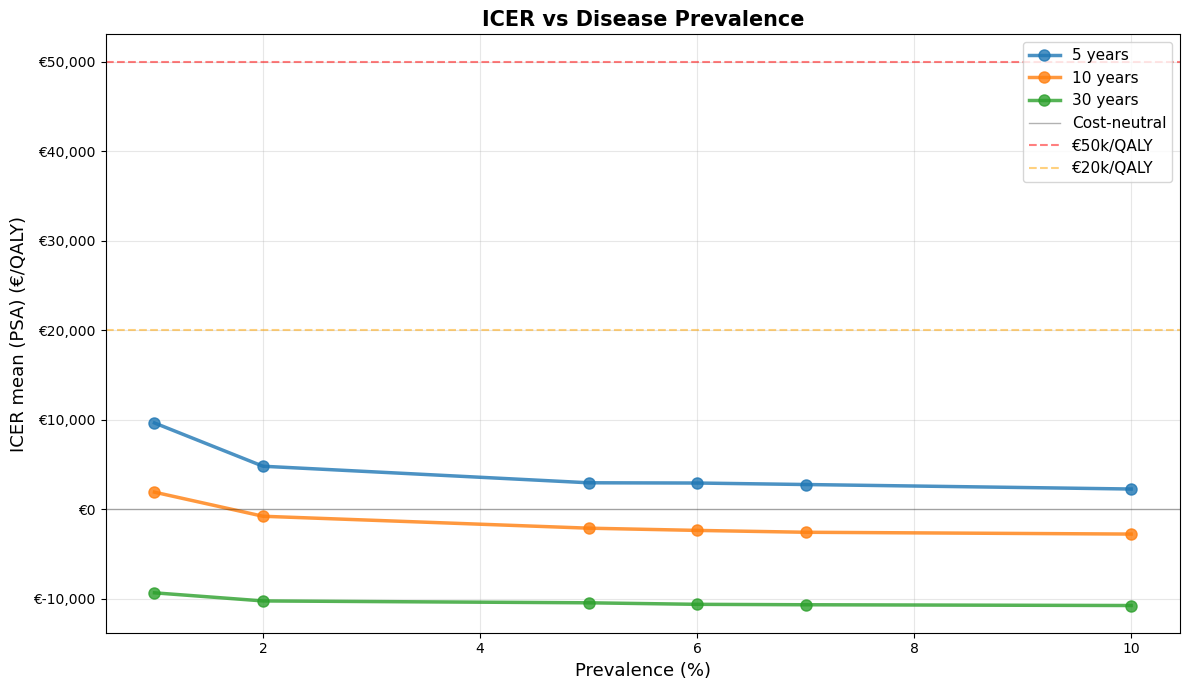

✓ Plot saved to ../data/prevalence_icer_plot.png


In [33]:
fig, ax = plt.subplots(figsize=(12, 7))

# Extract ICERs for different time horizons
prevalences_pct = [p * 100 for p in PREVALENCE_VALUES]

for horizon in [5, 10, 30]:
    icers = []
    for prev in PREVALENCE_VALUES:
        prev_key = f"{prev:.2f}"
        prev_key = prev
        icer = prevalence_sensitivity[prev_key][f'{horizon}_years']['summary']['icer_mean']
        icers.append(icer)
    
    ax.plot(prevalences_pct, icers, marker='o', linewidth=2.5, markersize=8, 
            label=f'{horizon} years', alpha=0.8)

# Add reference lines
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3, label='Cost-neutral')
ax.axhline(y=50000, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='€50k/QALY')
ax.axhline(y=20000, color='orange', linestyle='--', linewidth=1.5, alpha=0.5, label='€20k/QALY')

ax.set_xlabel('Prevalence (%)', fontsize=13)
ax.set_ylabel('ICER mean (PSA) (€/QALY)', fontsize=13)
ax.set_title('ICER vs Disease Prevalence', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

plt.tight_layout()
plt.savefig('../data/prevalence_icer_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to ../data/prevalence_icer_plot.png")

### 15.2 Probability Cost-Effective vs Prevalence

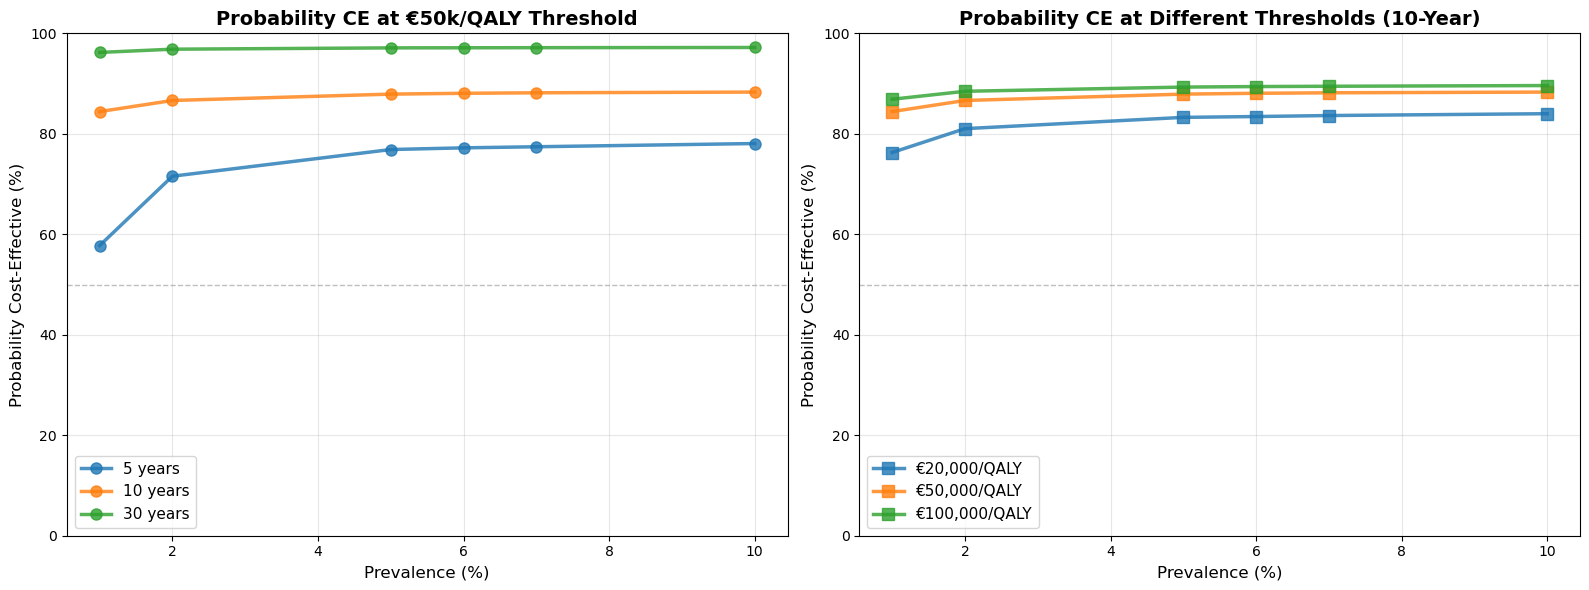

✓ Plot saved to ../data/prevalence_prob_ce_plot.png


In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Multiple time horizons at €50k threshold
for horizon in [5, 10, 30]:
    probs = []
    for prev in PREVALENCE_VALUES:
        prev_key = f"{prev:.2f}"
        prev_key = prev
        prob = prevalence_sensitivity[prev_key][f'{horizon}_years']['summary']['prob_cost_effective_50k']
        probs.append(prob)
    
    ax1.plot(prevalences_pct, probs, marker='o', linewidth=2.5, markersize=8, 
             label=f'{horizon} years', alpha=0.8)

ax1.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Prevalence (%)', fontsize=12)
ax1.set_ylabel('Probability Cost-Effective (%)', fontsize=12)
ax1.set_title('Probability CE at €50k/QALY Threshold', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.set_ylim(0, 100)
ax1.grid(alpha=0.3)

# Plot 2: 10-year results at different thresholds
for threshold in [20000, 50000, 100000]:
    probs = []
    for prev in PREVALENCE_VALUES:
        prev_key = f"{prev:.2f}"
        prev_key = prev
        threshold_key = f'prob_cost_effective_{threshold//1000}k'
        prob = prevalence_sensitivity[prev_key]['10_years']['summary'][threshold_key]
        probs.append(prob)
    
    ax2.plot(prevalences_pct, probs, marker='s', linewidth=2.5, markersize=8, 
             label=f'€{threshold:,}/QALY', alpha=0.8)

ax2.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Prevalence (%)', fontsize=12)
ax2.set_ylabel('Probability Cost-Effective (%)', fontsize=12)
ax2.set_title('Probability CE at Different Thresholds (10-Year)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.set_ylim(0, 100)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/prevalence_prob_ce_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to ../data/prevalence_prob_ce_plot.png")

### 15.3 Incremental Costs and QALYs vs Prevalence

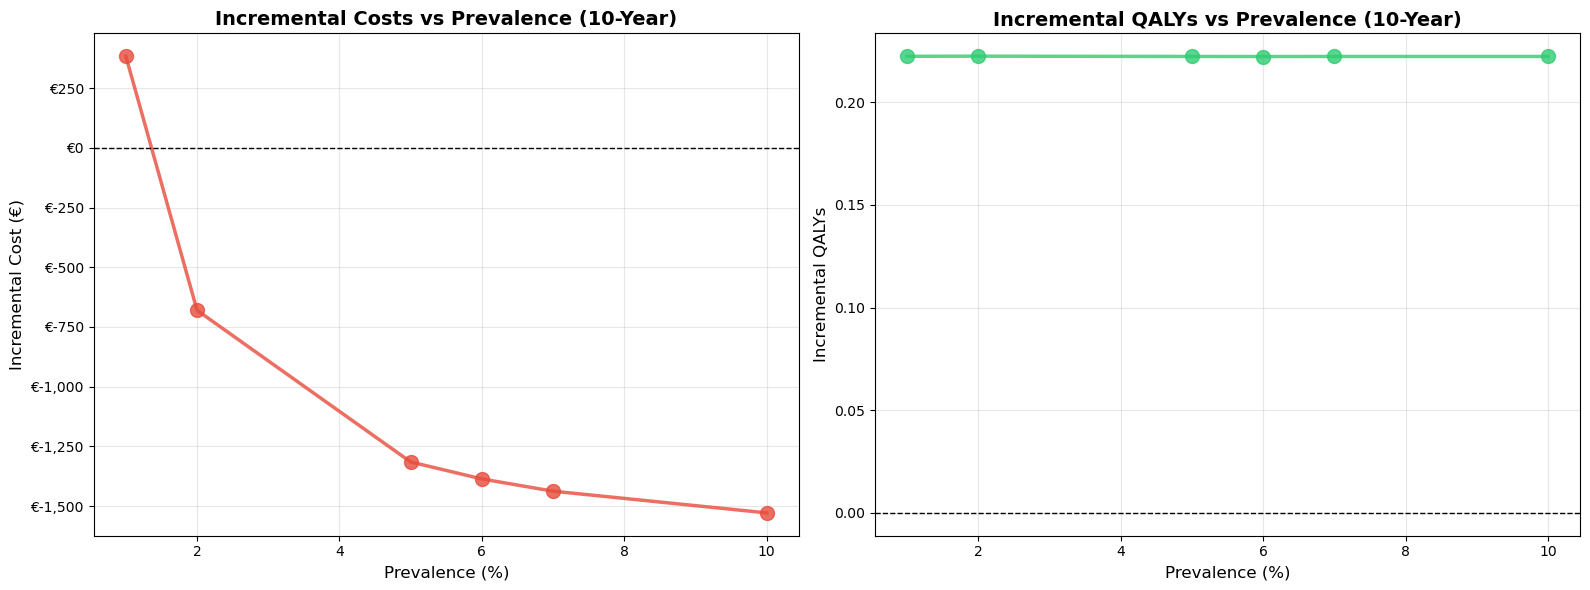

✓ Plot saved to ../data/prevalence_incremental_outcomes.png


In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Extract 10-year data
inc_costs = []
inc_qalys = []

for prev in PREVALENCE_VALUES:
    prev_key = f"{prev:.2f}"
    prev_key = prev
    results = prevalence_sensitivity[prev_key]['10_years']['summary']
    inc_costs.append(results['incremental_cost_mean'])
    inc_qalys.append(results['incremental_qaly_mean'])

# Plot 1: Incremental Costs
ax1.plot(prevalences_pct, inc_costs, marker='o', linewidth=2.5, markersize=10, 
         color='#e74c3c', alpha=0.8)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('Prevalence (%)', fontsize=12)
ax1.set_ylabel('Incremental Cost (€)', fontsize=12)
ax1.set_title('Incremental Costs vs Prevalence (10-Year)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

# Plot 2: Incremental QALYs
ax2.plot(prevalences_pct, inc_qalys, marker='o', linewidth=2.5, markersize=10, 
         color='#2ecc71', alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Prevalence (%)', fontsize=12)
ax2.set_ylabel('Incremental QALYs', fontsize=12)
ax2.set_title('Incremental QALYs vs Prevalence (10-Year)', fontsize=14, fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/prevalence_incremental_outcomes.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to ../data/prevalence_incremental_outcomes.png")

### 15.4 ICER Heatmap (Prevalence × Time Horizon)

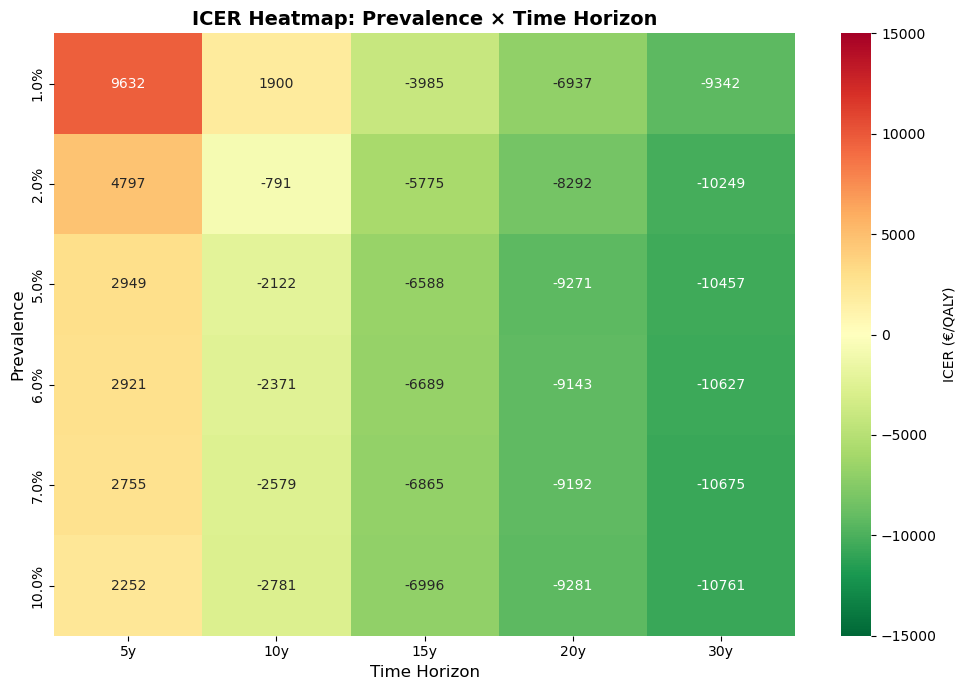

✓ Plot saved to ../data/prevalence_icer_heatmap.png


In [43]:
# Create ICER matrix
icer_matrix = []
for prev in PREVALENCE_VALUES:
    prev_key = f"{prev:.2f}"
    prev_key = prev
    row = []
    for horizon in TIME_HORIZONS:
        icer = prevalence_sensitivity[prev_key][f'{horizon}_years']['summary']['icer_mean']
        row.append(icer)
    icer_matrix.append(row)

icer_df = pd.DataFrame(
    icer_matrix,
    index=[f"{p:.1%}" for p in PREVALENCE_VALUES],
    columns=[f"{h}y" for h in TIME_HORIZONS]
)

fig, ax = plt.subplots(figsize=(10, 7))

# Create heatmap with diverging colormap
sns.heatmap(icer_df, annot=True, fmt='.0f', cmap='RdYlGn_r', center=0,
            cbar_kws={'label': 'ICER (€/QALY)'}, ax=ax, vmin=-15000, vmax=15000)

ax.set_xlabel('Time Horizon', fontsize=12)
ax.set_ylabel('Prevalence', fontsize=12)
ax.set_title('ICER Heatmap: Prevalence × Time Horizon', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/prevalence_icer_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot saved to ../data/prevalence_icer_heatmap.png")

## 16. Threshold Analysis

Find the prevalence threshold where AI screening becomes cost-effective

In [ ]:
print("\n" + "="*100)
print("PREVALENCE THRESHOLD ANALYSIS (10-YEAR HORIZON)")
print("="*100)

# Find thresholds for different WTP levels
for wtp_threshold, threshold_name in [(20000, '€20k'), (50000, '€50k'), (100000, '€100k')]:
    print(f"\nAt {threshold_name}/QALY threshold:")
    
    # Find where ICER crosses threshold
    for i, prev in enumerate(PREVALENCE_VALUES):
        prev_key = f"{prev:.2f}"
        icer = prevalence_sensitivity[prev_key]['10_years']['summary']['icer_mean']
        prob_ce_key = f"prob_cost_effective_{wtp_threshold//1000}k"
        prob_ce = prevalence_sensitivity[prev_key]['10_years']['summary'][prob_ce_key]
        
        if icer < wtp_threshold:
            print(f"  Cost-effective at prevalence ≥ {prev:.1%}")
            print(f"    ICER at {prev:.1%}: €{icer:,.0f}/QALY")
            print(f"    Probability CE: {prob_ce:.1f}%")
            break
    else:
        print(f"  Not cost-effective at any tested prevalence level")

# Find where AI becomes cost-saving
print(f"\nCost-Saving Threshold (ICER < €0):")
for prev in PREVALENCE_VALUES:
    prev_key = f"{prev:.2f}"
    icer = prevalence_sensitivity[prev_key]['10_years']['summary']['icer_mean']
    
    if icer < 0:
        print(f"  Cost-saving at prevalence ≥ {prev:.1%}")
        print(f"    ICER at {prev:.1%}: €{icer:,.0f}/QALY (cost-saving by €{-icer:,.0f}/QALY)")
        break
else:
    print(f"  Not cost-saving at any tested prevalence level")

## 17. Export Summary Tables

In [ ]:
# Save summary tables for all time horizons
for horizon in TIME_HORIZONS:
    summary = summarize_prevalence_sensitivity(prevalence_sensitivity, f'{horizon}_years')
    filename = f'../data/prevalence_sensitivity_{horizon}y.csv'
    summary.to_csv(filename, index=False)
    print(f"✓ Saved {horizon}-year summary to {filename}")

print("\n✓ All summary tables exported")

## 18. Conclusions

In [ ]:
print("\n" + "="*100)
print("PREVALENCE SENSITIVITY ANALYSIS - CONCLUSIONS")
print("="*100)

# Get key results
icer_at_1pct = prevalence_sensitivity['0.01']['10_years']['summary']['icer_mean']
icer_at_5pct = prevalence_sensitivity['0.05']['10_years']['summary']['icer_mean']
icer_at_10pct = prevalence_sensitivity['0.10']['10_years']['summary']['icer_mean']

prob_ce_at_1pct = prevalence_sensitivity['0.01']['10_years']['summary']['prob_cost_effective_50k']
prob_ce_at_5pct = prevalence_sensitivity['0.05']['10_years']['summary']['prob_cost_effective_50k']
prob_ce_at_10pct = prevalence_sensitivity['0.10']['10_years']['summary']['prob_cost_effective_50k']

print(f"\n1. IMPACT OF PREVALENCE ON COST-EFFECTIVENESS (10-YEAR HORIZON)")
print(f"   At 1% prevalence: ICER = €{icer_at_1pct:,.0f}/QALY")
print(f"   At 5% prevalence: ICER = €{icer_at_5pct:,.0f}/QALY")
print(f"   At 10% prevalence: ICER = €{icer_at_10pct:,.0f}/QALY")
print(f"\n   → ICER improvement from 1% to 10%: €{icer_at_1pct - icer_at_10pct:,.0f}/QALY")

print(f"\n2. PROBABILITY OF COST-EFFECTIVENESS AT €50K/QALY")
print(f"   At 1% prevalence: {prob_ce_at_1pct:.1f}%")
print(f"   At 5% prevalence: {prob_ce_at_5pct:.1f}%")
print(f"   At 10% prevalence: {prob_ce_at_10pct:.1f}%")

print(f"\n3. KEY INSIGHTS")
print(f"   • Cost-effectiveness improves substantially with higher prevalence")
print(f"   • Screening cost per detected case decreases linearly with prevalence")
print(f"   • False positive impact is proportionally larger at lower prevalence")

if icer_at_5pct < 0:
    print(f"   • AI screening is COST-SAVING at base case prevalence (5%)")
elif icer_at_5pct < 50000:
    print(f"   • AI screening is COST-EFFECTIVE at base case prevalence (5%)")

print(f"\n4. IMPLICATIONS FOR SCREENING PROGRAMS")
print(f"   • Target higher-risk populations for maximum efficiency")
print(f"   • Consider risk stratification before universal screening")
print(f"   • Cost-effectiveness threshold depends on target population prevalence")

print("\n" + "="*100)
print("ANALYSIS COMPLETE")
print("="*100)